In [118]:
import pandas as pd
import sys
sys.path.append("..")
from src.Utils import read_jsonlines
from src.Eval import get_iobs_from_data
import os

data = pd.read_parquet("../data/dataset/reddit+shsyt/data.parquet").drop_duplicates(subset="id")
data["yt_id"] = data.id.apply(lambda x: x.split("_", 1)[1])


data["has_WoA"] = data.IOB.apply(lambda x: "B-WoA" in x)
data["has_Artist"] = data.IOB.apply(lambda x: "B-Artist" in x)
data["index"] = data.groupby("subset").cumcount()


In [130]:
data.loc[(data.subset == 1) & (data["index"] == 35)]


,id,set_id,Origin,TEXT,IOB,subset,yt_id,has_WoA,has_Artist,index
8184,9373_D7pH8YSL_ac,9373.0,YouTube,"[[, pvhuru, ], banirabinzu, 「kids」, （, mgmt, c...","[O, O, O, B-Artist, B-WoA, O, B-Artist, O, O, ...",1,D7pH8YSL_ac,True,True,35


In [63]:

data_shs = pd.read_json("../data/raw/shs100k_metadata.jsonl", lines=True, orient="records")
data_shs = data_shs[['work_id', 'perf_id','perf_title', 'perf_artist']]
data_shs.columns = pd.MultiIndex.from_product([[''], data_shs.columns])

In [64]:
from typing import List
import sys
sys.path.append("../preprocessing")
from Processor import PerformerStringPreprocessor
from Utils import simplify_string, remove_bracket_with_one_content


def get_title_variations(s: str) -> List[str]:
    s = remove_bracket_with_one_content(s)
    l = s.split("/")
    l = [simplify_string(s) for s in l]
    return l

performer_processor = PerformerStringPreprocessor()

def get_performer_variations(s: str) -> List[str]:
    l = performer_processor.split_performers(s)
    l = [simplify_string(s) for s in l]
    l = performer_processor.article_preprocessing(l)
    return l

get_performer_variations("quentin tarantino feat. steven spielberg")


['quentin tarantino', 'steven spielberg']

# Factual Memorization

In [65]:
import pandas as pd
import ast

_ = pd.read_json("../data/intermediate/shs100k2_memorization.jsonl", lines=True, orient="records")

cols = []
for c in _.columns:
    new_c = ast.literal_eval(c)
    if new_c[1] == '':
        new_c = (new_c[1], new_c[0])
    cols.append(new_c)

_.columns = pd.MultiIndex.from_tuples(cols, names=["Model", ""])
_ = pd.merge(_, data_shs, 
                             how="left", on=[("", "work_id"), ("", "perf_id")])
# _ = _[[c for c in _.columns if "AW2" not in c[1]]]
_.columns = [(c[0], c[1].replace("AW3:", "AW2:")) for c in _.columns]
_ = _
_.columns = pd.MultiIndex.from_tuples(_.columns, names=["Model", ""])


In [66]:
models = []

for c in _.columns:
    model = c[0]
    if model != '' and model not in models:
        models.append(model)

        __ = _[model]

        _aw_cols = [c for c in __.columns if c.startswith("AW")]
        _aw_cols_related = [c for c in _aw_cols if "Related" in c]
        _aw_cols_correct = [c for c in _aw_cols if "Correct" in c]

        def correctness(row):
            if row[_aw_cols].T.sum() == 0:
                return "None"
            elif row[_aw_cols_correct].T.sum() >= 2:
                return "Both Correct"
            elif row[_aw_cols_correct].T.sum() == 1:
                return "One Correct"
            else:
                return "Partial"
            
        _[(model, "Correctness")] = __.apply(correctness, axis=1)
        _[(model, "Correctness")].value_counts()

__ = _[[("", "set_id")] + [(model, "Correctness") for model in models]]
__.columns = ["set_id"] + [f"{model}_Correctness" for model in models]
data_memorization = pd.merge(data, __, on="set_id", how="left")
data_memorization



,id,set_id,Origin,TEXT,IOB,subset,yt_id,has_WoA,has_Artist,index,FireFunction-v2_Correctness,GPT-4o-mini_Correctness,Llama3.1-70B_Correctness,Llama3.1-8B_Correctness,Mixtral-8x22B_Correctness
0,21_L1-t3YvFH40,21.0,YouTube,"[gladys, knight, &, the, pips, -, yesterday]","[B-Artist, I-Artist, O, B-Artist, I-Artist, O,...",5,L1-t3YvFH40,True,True,0,Both Correct,One Correct,Both Correct,Both Correct,Both Correct
1,21_L1-t3YvFH40,21.0,YouTube,"[gladys, knight, &, the, pips, -, yesterday]","[B-Artist, I-Artist, O, B-Artist, I-Artist, O,...",5,L1-t3YvFH40,True,True,0,Partial,Partial,One Correct,One Correct,One Correct
2,21_4SE8UvqaSWQ,21.0,YouTube,"[hooked, on, the, beatles, -, the, end]","[B-WoA, I-WoA, I-WoA, I-WoA, O, B-WoA, I-WoA]",5,4SE8UvqaSWQ,True,False,1,Both Correct,One Correct,Both Correct,Both Correct,Both Correct
3,21_4SE8UvqaSWQ,21.0,YouTube,"[hooked, on, the, beatles, -, the, end]","[B-WoA, I-WoA, I-WoA, I-WoA, O, B-WoA, I-WoA]",5,4SE8UvqaSWQ,True,False,1,Partial,Partial,One Correct,One Correct,One Correct
4,58_hQz-aZH-ozU,58.0,YouTube,"[juan, rozoff, -, plaisir, d, amour]","[B-Artist, I-Artist, O, B-WoA, I-WoA, I-WoA]",1,hQz-aZH-ozU,True,True,0,Partial,Partial,Partial,One Correct,Partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119,dataset4_709,12481.0,Reddit,"[songs, like, sub, urbams, cradle, ?]","[O, O, B-Artist, I-Artist, B-WoA, O]",3,709,True,True,599,NaN,NaN,NaN,NaN,NaN
3120,dataset4_710,12482.0,Reddit,"[songs, /, artists, like, quarter, past, midni...","[O, O, O, O, B-WoA, I-WoA, I-WoA, O, B-Artist]",4,710,True,True,590,NaN,NaN,NaN,NaN,NaN
3121,dataset4_711,12483.0,Reddit,"[soft, -, voiced, vocals]","[O, O, O, O]",5,711,False,False,592,NaN,NaN,NaN,NaN,NaN
3122,dataset4_712,12484.0,Reddit,"[find, me, music, with, dark, lyrics, covered,...","[O, O, O, O, O, O, O, O, O, O, O, O, O]",1,712,False,False,593,NaN,NaN,NaN,NaN,NaN


# Exposure

In [67]:
_ = pd.read_json("../data/intermediate/shs100k2_exposure.jsonl", lines=True, orient="records")

__ = pd.read_parquet("../data/raw/shs100k2_yt.parquet")[["set_id", "yt_id", "title", "performer"]]
__.title = __.title.str.lower()
__.performer = __.performer.str.lower()

_map = __.set_index(["set_id", "yt_id"]).to_dict()
data["title"] = data.apply(lambda x: _map["title"].get((x.set_id, x.yt_id)), axis=1)
data["performer"] = data.apply(lambda x: _map["performer"].get((x.set_id, x.yt_id)), axis=1)


_ = pd.concat(
    [pd.merge(
        data, 
        _.loc[_.Entity == "WoA"], 
        left_on=["set_id", "title"], 
        right_on=["set_id", "name"],
        how="left"),
     pd.merge(
         data, 
         _.loc[_.Entity == "Artist"], 
         left_on=["set_id", "performer"], 
         right_on=["set_id", "name"], 
         how="left")]
).drop("yt_id_y", axis=1).rename(
    columns={"yt_id_x": "yt_id"}).drop_duplicates(subset=["id", "Entity"])


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
2024-09-15 12:51:35 matpl

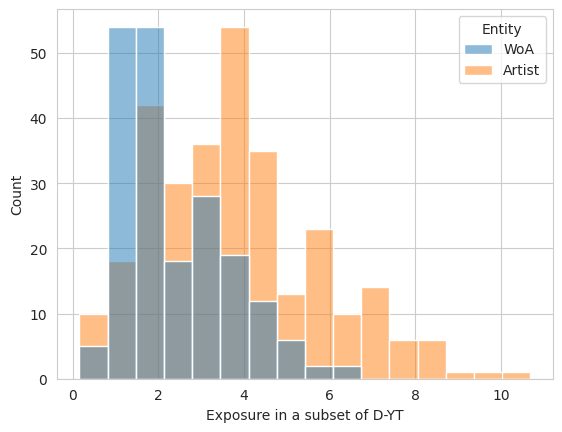

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.histplot(_.dropna(subset="exposure_max"), x="exposure_max", hue="Entity")
plt.xlabel("Exposure in a subset of D-YT")
plt.savefig("../figures/hist_exposure_dataset.pdf")
plt.show()


In [69]:
data_exposure = _.pivot_table(index=['id'],
                              columns='Entity',
                              values=['name', 'sitelinks_max', 'exposure_max'],
                              aggfunc='first').reset_index()
data_exposure.columns = ["id", "exposure_Artist", "exposure_WoA", "name_Artist", "name_WoA", "sitelinks_Artist", "sitelinks_WoA"]
data_exposure


,id,exposure_Artist,exposure_WoA,name_Artist,name_WoA,sitelinks_Artist,sitelinks_WoA
0,1009_1MuNPBL0hMg,1.008419,NaN,vsop,NaN,1.0,NaN
1,1026_Ng4uw6k2RVM,4.324027,1.008419,john kay,i'm movin' on,21.0,1.0
2,1026_idphZ2fY_a0,5.012986,NaN,duane eddy,NaN,29.0,NaN
3,102_O3mnspFrGj8,NaN,2.965611,NaN,you'll never walk alone,NaN,9.0
4,102_nbkPuH9rjKs,4.852235,2.965611,trisha yearwood,you'll never walk alone,27.0,9.0
...,...,...,...,...,...,...,...
389,9840_1FEB2_ywkjU,2.301332,NaN,margie joseph,NaN,5.0,NaN
390,986_6XuJ0E1Qu_c,6.981762,1.008419,django reinhardt,fine and dandy,64.0,1.0
391,9912_nuJnW0ow4bY,3.822592,NaN,little milton,NaN,16.0,NaN
392,9960_wK63eUyk-iM,8.632872,NaN,john travolta,NaN,113.0,NaN


# Results
##### Join Factual Memorization & Wikidata Exposure

In [170]:
data_joint = pd.merge(data_memorization, data_exposure, on="id", how="left")


In [171]:
output_path = "../output/reddit+shsyt/"

def get_IOB_preds(output_path) -> pd.DataFrame:
    """Get multiindex dataframe with predicted IOB lists.
    Args:
        output_path (_type_): _description_
    Returns:
        pd.DataFrame: _description_
    """
    def remove_duplicates(input_list):
        seen = set()
        return [x for x in input_list if not (x["text"] in seen or seen.add(x["text"]))]

    data = pd.DataFrame()

    for model in os.listdir(output_path):
        for f in os.listdir(os.path.join(output_path, model)):
            _ = f.split(".")[0].split("_")
            dataset, k = _[0], int(_[1].replace("shot", ""))
            sampling = _[2] if len(_) > 2 else ""

            preds = read_jsonlines(os.path.join(output_path, model, f))
            _data = pd.DataFrame(preds).set_index("text")
            _, pred_iobs = get_iobs_from_data(preds)
            _data["IOB_pred"] = pred_iobs
            _data =  _data.loc[~_data.index.duplicated(keep="first"),["IOB_pred"]]
            
            _data.columns =  pd.MultiIndex.from_product([[model], [k], [sampling]])

            _new_cols = _data.columns.difference(data.columns)
    
            if not _new_cols.empty:
                data = pd.concat([data, _data[_new_cols]], axis=1, join='outer')
            else:
                data = data.combine_first(_data)
    
    return data
         
preds = get_IOB_preds(output_path)


0                    gladys knight & the pips - yesterday
1                    gladys knight & the pips - yesterday
2                         hooked on the beatles - the end
3                         hooked on the beatles - the end
4                           juan rozoff - plaisir d amour
                              ...                        
3119                       songs like sub urbams cradle ?
3120    songs / artists like quarter past midnight by ...
3121                                 soft - voiced vocals
3122    find me music with dark lyrics covered by an u...
3123    looking for an album or ep in cassette tape fo...
Name: TEXT, Length: 3124, dtype: object

In [174]:
data_joint2 = data_joint.set_index(
    data_joint.TEXT.apply(' '.join)
)


# Results!

In [178]:
import sys
sys.path.append("..")
from src.Eval import compute_results
from contextlib import redirect_stdout
import re


def get_model_pred_col(pred_df: pd.DataFrame, model: str) -> str:
    level_values = pred_df.columns.get_level_values(level=0)
    if model.lower() in level_values:
        return model.lower()
    elif model.replace("-", ":").lower() in level_values:
        return model.replace("-", ":").lower()
    return None

def suppress_output(func, *args, **kwargs):
    with open(os.devnull, 'w') as fnull:
        with redirect_stdout(fnull):
            return func(*args, **kwargs)      

def get_results_per_factual_memorization_cls(k, sampling):
    
    correctness_cols = [c for c in data_joint.columns if "_Correctness" in c]
    results = {}   

    data_joint2 = data_joint.set_index(
        data_joint.TEXT.apply(' '.join)
    )

    for correctness_col in correctness_cols:
        model = correctness_col.split("_")[0]

        col = (get_model_pred_col(preds, model), k, sampling)

        results[model] = {}
        for group in data_joint[correctness_col].dropna().unique():
            try:
                _data = data_joint2.loc[data_joint2[correctness_col] == group].join(
                    preds.loc[:,col].rename("IOB_pred"), how="inner").dropna(subset=["IOB", "IOB_pred"])
                iob_true = _data.IOB.values
                iob_pred = _data.IOB_pred.values
                results[model][group] = {}

                kwargs = {"true_labels": iob_true, "true_predictions": iob_pred}
                values = suppress_output(compute_results, **kwargs)
                metrics = ["overall_strict_f1_macro", "overall_strict_recall_macro", "Artist_strict_recall", "WoA_strict_recall"]
                for metric in metrics:
                    results[model][group][metric] = values[metric]
            except:
                print(f"Skipping for {col}")

    data = pd.json_normalize(results, sep='_')
    data.columns = pd.MultiIndex.from_tuples([tuple(col.split('_')) for col in data.columns])
    return data.stack(level=1)

k = 35
sampling = "tfidf"
get_results_per_factual_memorization_cls(k, sampling)


2024-09-15 13:54:32 root INFO: Imported 302 predictions for 302 true examples


2024-09-15 13:54:32 root INFO: Imported 99 predictions for 99 true examples
2024-09-15 13:54:32 root INFO: Imported 290 predictions for 290 true examples
2024-09-15 13:54:32 root INFO: Imported 60 predictions for 60 true examples
2024-09-15 13:54:32 root INFO: Imported 123 predictions for 123 true examples
2024-09-15 13:54:32 root INFO: Imported 36 predictions for 36 true examples
2024-09-15 13:54:32 root INFO: Imported 101 predictions for 101 true examples
2024-09-15 13:54:32 root INFO: Imported 36 predictions for 36 true examples
2024-09-15 13:54:32 root INFO: Imported 321 predictions for 321 true examples
2024-09-15 13:54:33 root INFO: Imported 214 predictions for 214 true examples
2024-09-15 13:54:33 root INFO: Imported 49 predictions for 49 true examples
2024-09-15 13:54:33 root INFO: Imported 45 predictions for 45 true examples
2024-09-15 13:54:33 root INFO: Imported 388 predictions for 388 true examples


Skipping for (None, 35, 'tfidf')
Skipping for (None, 35, 'tfidf')
Skipping for (None, 35, 'tfidf')
Skipping for (None, 35, 'tfidf')


2024-09-15 13:54:33 root INFO: Imported 252 predictions for 252 true examples
2024-09-15 13:54:33 root INFO: Imported 65 predictions for 65 true examples
2024-09-15 13:54:33 root INFO: Imported 46 predictions for 46 true examples
/tmp/ipykernel_3050184/3876496025.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return data.stack(level=1)


FireFunction-v2                               GPT-4o-mini  \
                       overall              Artist       WoA     overall   
                        strict              strict    strict      strict   
                            f1    recall    recall    recall          f1   
                         macro     macro       NaN       NaN       macro   
0 Both Correct        0.778126  0.735976  0.784452  0.687500    0.863646   
  None                0.690476  0.650418  0.765625  0.535211    0.760369   
  One Correct         0.801598  0.753937  0.831615  0.676259    0.797301   
  Partial             0.810955  0.758550  0.840909  0.676190    0.825000   

                                             Llama3.1-70B                      \
                            Artist       WoA      overall              Artist   
                            strict    strict       strict              strict   
                  recall    recall    recall           f1    recall    recall   
                   macro       NaN       NaN        macro     macro       NaN   
0 Both Correct  0.857143  0.877551  0.836735     0.787255  0.762224  0.754967   
  None          0.688160  0.735294  0.641026     0.698428  0.647143  0.714286   
  One Correct   0.763195  0.780488  0.745902     0.774704  0.741917  0.775701   
  Partial       0.790747  0.870968  0.710526     0.812743  0.783801  0.755102   

                         Mixtral-8x22B                                
                     WoA       overall              Artist       WoA  
                  strict        strict              strict    strict  
                  recall            f1    recall    recall    recall  
                     NaN         macro     macro       NaN       NaN  
0 Both Correct  0.769481      0.830619  0.796397  0.784574  0.808219  
  None          0.580000      0.754167  0.713333  0.760000  0.666667  
  One Correct   0.708134      0.811623  0.777626  0.851695  0.703557  
  Partial       0.812500      0.745516  0.706657  0.796875  0.616438

In [169]:
data_joint.TEXT

subset  index
5       0                     gladys knight & the pips - yesterday
        1                          hooked on the beatles - the end
1       0                            juan rozoff - plaisir d amour
        1                           ub40 cant help falling in love
        2         pearl jam - i cant help falling in love with you
                                       ...                        
3       599                         songs like sub urbams cradle ?
4       590      songs / artists like quarter past midnight by ...
5       592                                   soft - voiced vocals
1       593      find me music with dark lyrics covered by an u...
2       598      looking for an album or ep in cassette tape fo...
Name: TEXT, Length: 2976, dtype: object

In [12]:
def get_results_exposure(k, sampling, exposure_threshold):

    results = {}   

    for model in preds.columns.get_level_values(level=0).unique():
        col = (model, k, sampling)
        if not results.get(model):
            results[model] = {}

        for group in ["seen", "unseen"]:
            for cls in ["Artist", "WoA"]:
                if group == "seen":
                    mask = data_joint[f"exposure_{cls}"] >= exposure_threshold
                else:
                    mask = data_joint[f"exposure_{cls}"].fillna(0) < exposure_threshold

                _data = data_joint.loc[mask].join(
                    preds.loc[:,col].rename("IOB_pred"), how="inner").dropna(subset=["IOB", "IOB_pred", f"exposure_{cls}"])
                iob_true = _data.IOB.values
                iob_pred = _data.IOB_pred.values

                if not results[model].get(cls):
                    results[model][cls] = {}
                if not results[model][cls].get(group):
                    results[model][cls][group] = {}

                kwargs = {"true_labels": iob_true, "true_predictions": iob_pred}
                values = suppress_output(compute_results, **kwargs)
                metrics = ["Artist_strict_recall", "WoA_strict_recall"]
                for metric in metrics:
                    if "overall_" in metric or cls + '_' in metric:
                        results[model][cls][group][metric.split("_")[-1]] = values[metric]

    data = pd.json_normalize(results, sep='_')
    data.columns = pd.MultiIndex.from_tuples([tuple(col.split('_')) for col in data.columns])
    return data.stack(level=2)

get_results_exposure(k, sampling, 1.5)


2024-09-15 12:02:21 root INFO: Imported 296 predictions for 296 true examples
2024-09-15 12:02:21 root INFO: Imported 150 predictions for 150 true examples
2024-09-15 12:02:21 root INFO: Imported 67 predictions for 67 true examples
2024-09-15 12:02:21 root INFO: Imported 104 predictions for 104 true examples


KeyError: ('gpt-4o-mini', 35, 'tfidf')